<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81-%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB%20%D0%B4%D0%BB%D1%8F%20%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D0%BC%D0%BE%D1%80%D1%84%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 996.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b0c482930883983a2d39ae2ad711371f448841fe200b0d7fdf77d75a41655305
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [7]:
import os
import glob
import re
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import pymorphy2

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Изменение имени файла
dictionary_file = "cleaned_tihonov (5).txt"

# Инициализация pymorphy
morph = pymorphy2.MorphAnalyzer()

# Считываем словарь морфем
morpheme_dictionary = {}
with open(dictionary_file, 'r', encoding='utf-8') as dict_file:
    for line in dict_file:
        line = line.strip()
        if line:
            word, morphemes = line.split()  # Используем split без аргументов для автоматического разделения по пробелам или табуляции
            morpheme_count = morphemes.count('/') + morphemes.count('(') + 1  # Считаем и символы '/' и '('
            morpheme_dictionary[word.lower()] = morpheme_count

# Список для хранения данных
data = []
# Переменная для хранения количества лемм, которые не совпадают со словарем морфем
non_matching_lemmas = 0

# Список для хранения среднего количества морфем в каждом файле
avg_morpheme_counts_all = []

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    avg_morpheme_counts = []

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = re.findall(r'\b\w+\b', text)

            total_morpheme_count = 0
            token_count = 0

            # Вычисляем количество морфем для каждого токена
            for token in tokens:
                # Лемматизируем токен
                lemma = morph.parse(token)[0].normal_form
                # Проверяем наличие леммы в словаре морфем
                if lemma in morpheme_dictionary:
                    morpheme_count = morpheme_dictionary[lemma]
                    total_morpheme_count += morpheme_count
                    token_count += 1
                else:
                    # Если лемма не найдена в словаре морфем, увеличиваем счетчик
                    non_matching_lemmas += 1

            # Среднее количество морфем для файла
            avg_morpheme_count = total_morpheme_count / token_count if token_count > 0 else 0
            avg_morpheme_counts.append(avg_morpheme_count)

            # Добавляем данные в список для анализа
            data.append((cefr_level, avg_morpheme_count))

    # Добавляем средние значения в общий список
    avg_morpheme_counts_all.extend(avg_morpheme_counts)

# Вычисляем статистики для количества морфем во всех файлах
mean_morpheme_count_all = np.mean(avg_morpheme_counts_all)
sd_morpheme_count_all = np.std(avg_morpheme_counts_all)
std_error_morpheme_count_all = stats.sem(avg_morpheme_counts_all)
ci_morpheme_count_all = stats.t.interval(0.95, len(avg_morpheme_counts_all) - 1, loc=mean_morpheme_count_all, scale=std_error_morpheme_count_all)

# Выводим статистики для количества морфем во всех файлах
print("Статистики для количества морфем во всех файлах:")
print(f"Mean: {mean_morpheme_count_all}")
print(f"SD: {sd_morpheme_count_all}")
print(f"Std. Error: {std_error_morpheme_count_all}")
print(f"95% CI (confidence interval) (mean): {ci_morpheme_count_all}")

# Выводим количество лемм, не совпадающих со словарем морфем
print(f"Количество лемм, не совпадающих со словарем морфем: {non_matching_lemmas}")

# Создаем DataFrame
df = pd.DataFrame(data, columns=['CEFR Level', 'Avg Morpheme Count'])

# ANOVA
anova_result = pg.anova(data=df, dv='Avg Morpheme Count', between='CEFR Level')

# Тест Геймса-Хауэлла
games_howell_result = pg.pairwise_gameshowell(data=df, dv='Avg Morpheme Count', between='CEFR Level')

# Вывод результатов
print(f"F-статистика (ANOVA): {anova_result['F'][0]}")
print(f"p-value (ANOVA): {anova_result['p-unc'][0]}")

print("\nGames-Howell Test Results:")
print(games_howell_result)

Статистики для количества морфем во всех файлах:
Mean: 2.170072504796578
SD: 0.16974849295130706
Std. Error: 0.00512744074506932
95% CI (confidence interval) (mean): (2.1600117952971405, 2.1801332142960157)
Количество лемм, не совпадающих со словарем морфем: 56133
F-статистика (ANOVA): 58.57099045472108
p-value (ANOVA): 4.0977540629809744e-35

Games-Howell Test Results:
    A   B   mean(A)   mean(B)      diff        se          T          df  \
0  A1  A2  2.104739  2.110420 -0.005681  0.030446  -0.186591   71.024903   
1  A1  B1  2.104739  2.199335 -0.094596  0.030168  -3.135628   68.493248   
2  A1  B2  2.104739  2.300146 -0.195407  0.031869  -6.131542   84.086064   
3  A2  B1  2.110420  2.199335 -0.088915  0.010274  -8.654024  872.226850   
4  A2  B2  2.110420  2.300146 -0.189726  0.014529 -13.058617  238.437431   
5  B1  B2  2.199335  2.300146 -0.100811  0.013937  -7.233102  206.751464   

           pval    hedges  
0  9.976739e-01 -0.032613  
1  1.317339e-02 -0.600399  
2  1.62200

In [8]:
import os
import glob
import re
import pymorphy2

# Изменение имени файла
dictionary_file = "cleaned_tihonov (5).txt"

# Инициализация pymorphy
morph = pymorphy2.MorphAnalyzer()

# Считываем словарь морфем
morpheme_dictionary = {}
with open(dictionary_file, 'r', encoding='utf-8') as dict_file:
    for line in dict_file:
        line = line.strip()
        if line:
            word, morphemes = line.split()  # Используем split без аргументов для автоматического разделения по пробелам или табуляции
            morpheme_count = morphemes.count('/') + morphemes.count('(') + 1  # Считаем и символы '/' и '('
            morpheme_dictionary[word.lower()] = morpheme_count

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Переменная для хранения количества лемм, совпадающих со словарем морфем
matching_lemmas = 0

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = re.findall(r'\b\w+\b', text)

            # Вычисляем количество лемм, совпадающих со словарем морфем
            for token in tokens:
                # Лемматизируем токен
                lemma = morph.parse(token)[0].normal_form
                # Проверяем совпадение леммы со словарем морфем
                if lemma in morpheme_dictionary:
                    matching_lemmas += 1

# Выводим количество лемм, совпадающих со словарем морфем
print(f"Количество лемм, совпадающих со словарем морфем: {matching_lemmas}")

Количество лемм, совпадающих со словарем морфем: 131494


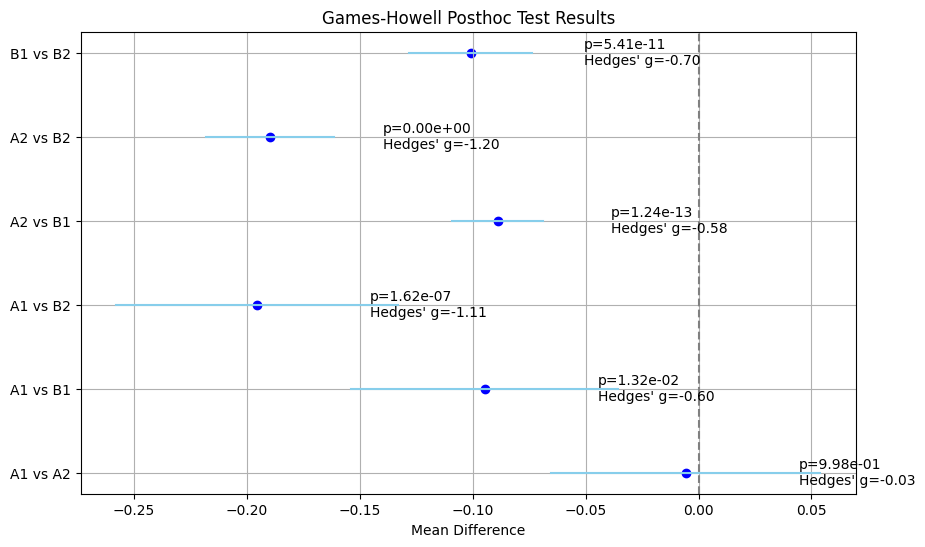

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Результаты теста Геймса-Хауэла
games_howell_result = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [2.104739, 2.104739, 2.104739, 2.110420, 2.110420, 2.199335],
    'mean(B)': [2.110420, 2.199335, 2.300146, 2.199335, 2.300146, 2.300146],
    'diff': [-0.005681, -0.094596, -0.195407, -0.088915, -0.189726, -0.100811],
    'se': [0.030446, 0.030168, 0.031869, 0.010274, 0.014529, 0.013937],
    'T': [-0.186591, -3.135628, -6.131542, -8.654024, -13.058617, -7.233102],
    'df': [71.024903, 68.493248, 84.086064, 872.226850, 238.437431, 206.751464],
    'pval': [9.976739e-01, 1.317339e-02, 1.622001e-07, 1.240119e-13, 0.000000e+00, 5.405698e-11],
    'hedges': [-0.032613, -0.600399, -1.109972, -0.577046, -1.196744, -0.704384]
})

# Расчет доверительных интервалов
z_score = 1.96
conf_intervals = [
    (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
]

# Построение графика
plt.figure(figsize=(10, 6))
for i, (group, ci, p, h) in enumerate(
    zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
):
    plt.plot(ci, [i, i], color="skyblue")
    plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
    plt.text(games_howell_result['diff'].iloc[i] + 0.05, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center')

# Элементы оформления
plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Mean Difference")
plt.title("Games-Howell Posthoc Test Results")
plt.grid(True)
plt.show()